<a href="https://colab.research.google.com/github/robd123/AML/blob/main/Project2/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC 686 Project 1


*   This project uses the Epicurious dataset, which contains nutritional data and assorted information about.
*   Data is downloaded and bad data is removed.
*   Correlation between rating and data attributes is studied.
*   PCA decomposition is performed.
*   Logistic regression is performed to predict some binary attributes.
*   A new 'healthy' attribute is introduced, and its effect on correlation and regression is studied.



In [ ]:
import urllib.request
import os
datapath = os.path.join("datasets", "epi", "")
os.makedirs(datapath, exist_ok=True)
file_path = "https://raw.githubusercontent.com/robd123/AML/main/Project2/epi_r.csv"
urllib.request.urlretrieve(file_path, datapath + "epi_r.csv")

('datasets/epi/epi_r.csv', <http.client.HTTPMessage at 0x7f2bb8f75410>)

**Data Preprocessing**


*   Replace missing values with median values.
*   Use standard scaler.
*   Remove food with less than 50 calories, most of these are recipes for preparing ingredients like stock or clarified butter.  Since we're trying to rate meals they can be safely removed.
*   Remove food with over 5000 calories.  Since the goal is to rate meals, there needs to be some way to correct for serving size.  
*  Epicurious does not allow a zero rating, so any recipe that has a zero has not been rated.  This can be considered missing data, since its the value I'm trying to predict it doesn't make to give use the imputer to fill it in.
*  Remove recipes with over 5000 mg of sodium.  This level of sodium intake in a single meal can be dangerous.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

food = pd.read_csv(datapath + "epi_r.csv", thousands=',')
food.sort_values(by=['calories'], ascending=False).head()

food = food.drop(columns = ['title', 'bon appétit'])  #remove title and bon apetit, which appears to be a reflection of the rating of the food and does not contribute to it
food = food[food.calories > 50]  # Remove ingredients
food = food[food.calories < 5000]  # Remove foods that have way more calories than can be considered a meal
food = food[food.sodium < 5000]  # Remove meals that have a hazardous amount of sodium
food = food[food.rating > 0]  # Remove unrated recipes
food = food.drop_duplicates(keep='first')  # Remove duplicate recipes

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

food_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

food_ct = food[['rating', 'calories', 'protein', 'fat', 'sodium']]
food_non_ct = food.drop(columns = ['rating', 'calories', 'protein', 'fat', 'sodium'])

#Only transform continuous attributes
food_scaled_ct = food_pipeline.fit_transform(food_ct)

#Concatenate continuous and binary attributes back together, maintaining binary values for non-continuous attributes
food_scaled = np.concatenate((food_scaled_ct, food_non_ct), axis = 1)

#All attributes as a data frame
food_scaled = pd.DataFrame(food_scaled, columns = food.columns)

#Only continuous attributes as a data frame
food_scaled_ct = pd.DataFrame(food_scaled_ct, columns = ['rating', 'calories', 'protein', 'fat', 'sodium'])

Correlation of all attributes with the rating.  Thanksgiving, roast, christmas, and fat top the list for obvious reasons.

In [ ]:
food_scaled.corr()['rating'].sort_values(ascending=False)

rating          1.000000
thanksgiving    0.059346
roast           0.053098
christmas       0.047425
fat             0.047033
                  ...   
rub                  NaN
sorbet               NaN
waffle               NaN
windsor              NaN
leftovers            NaN
Name: rating, Length: 678, dtype: float64

Correlation of only continuous attributes with rating.  Fat and calories are at the top, again for obvious reasons.

In [ ]:
food_scaled_ct.corr()['rating'].sort_values(ascending=False)

rating      1.000000
fat         0.047033
calories    0.046455
sodium      0.036407
protein     0.035439
Name: rating, dtype: float64

Histograms of continuous data.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2bb8cdc850>,
      dtype=object)

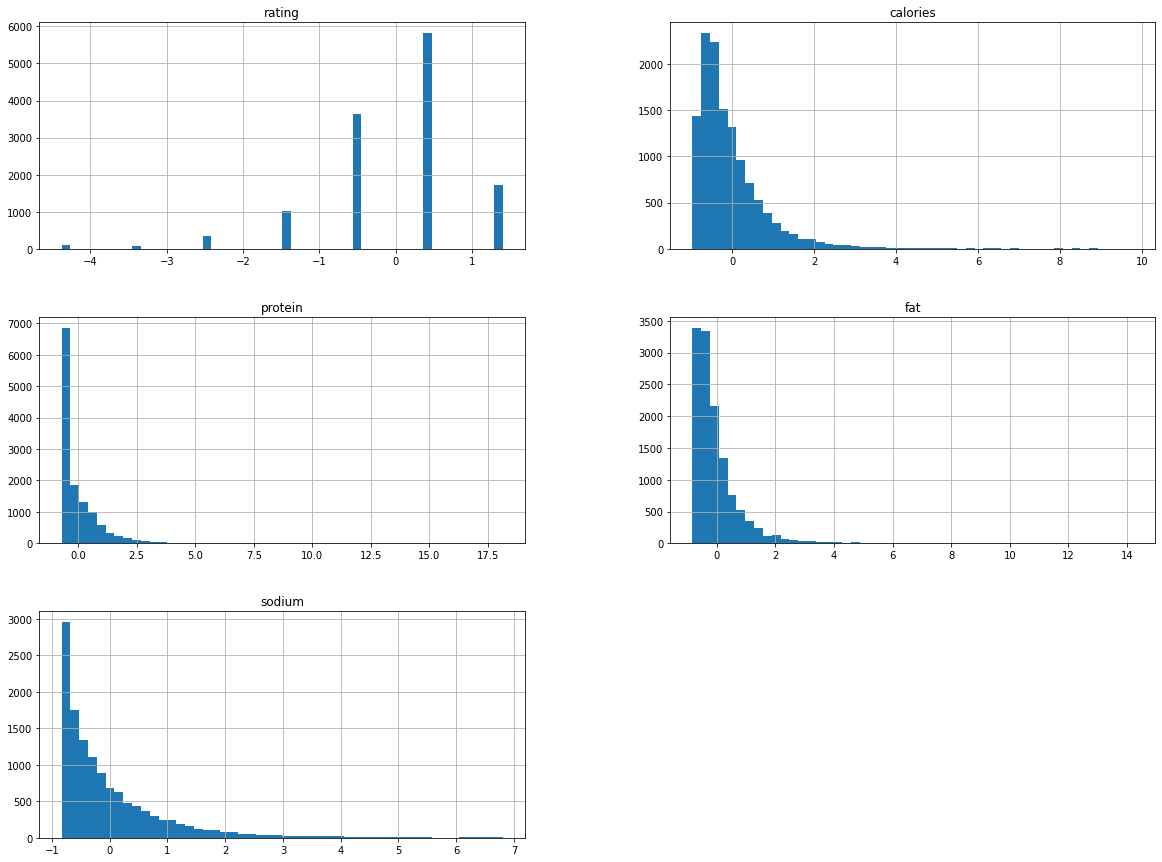

In [ ]:
food_scaled_ct.hist(bins=50, figsize=(20,15))

Scatter plot for continuous attributes.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2bb8985fd0>,
      dtype=object)

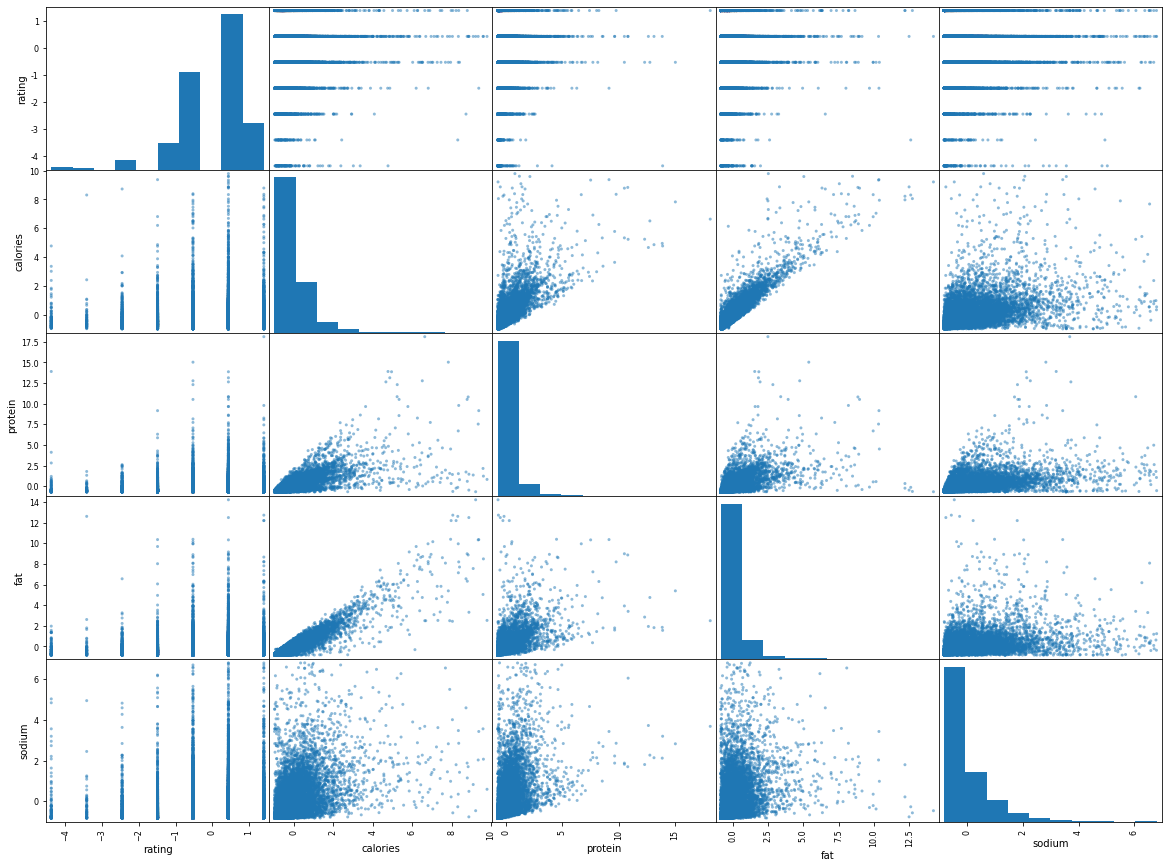

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ['rating', 'calories', 'protein', 'fat', 'sodium']
scatter_matrix(food_scaled_ct[attributes], figsize=(20,15))


PCA decomposition for the data set. 

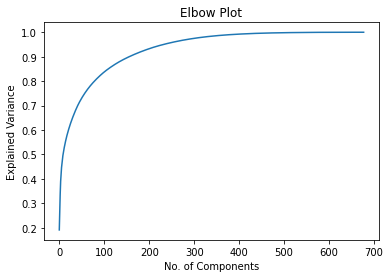

In [ ]:
from sklearn.decomposition import PCA

food_pca = PCA()
food_pca.fit(food_scaled)
tr_food_pca = food_pca.transform(food_scaled)

plt.plot(np.cumsum(food_pca.explained_variance_ratio_))
plt.xlabel('No. of Components')
plt.ylabel('Explained Variance')
plt.title('Elbow Plot')
plt.show()

Number of attributes that explain 95 percent of the variance.

In [ ]:
cumsum = np.cumsum(food_pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)

233


# Logistic Regression


---

*   I will be using Logistic Regression to attempt to predict the following categories: '#cakeweek', '22-minute meals', '3-ingredient recipes', 'appetizer', 'alcoholic', and 'vegetartian'.
*   I am also removing the opposite values of some of the categories that I will be predicting, 'non-alcoholic' and 'meat'.  While this will necessarily make the predictions less accurate, it makes sense that prediction shouldn't be based simply on the absence of one category.



In [ ]:
# Split data set into dependent and independent variables
food_scaled = food_scaled.drop(columns = ['#cakeweek', '22-minute meals', '3-ingredient recipes', 'appetizer', 'alcoholic', 'non-alcoholic', 'vegetarian', 'meat'])
X = food_scaled # Independent Variables
Y = food[['#cakeweek', '#wasteless', '22-minute meals', '3-ingredient recipes', 'appetizer', 'alcoholic', 'vegetarian']]  # Dependent Variables

KeyError: ignored

**Logistic Regression for #Cakeweek**


---


Due to an extremely low number of #Cakeweek recipes, this regression model doesn't work very well.  Or it works great as it accurately predicts that nearly all recipes aren't cakeweek.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

X_train, X_test, Y_train, Y_test = train_test_split(X, Y[['#cakeweek']], test_size = 0.30, random_state = 0)

classifier = LogisticRegression()
classifier.fit(X_train, Y_train)

cake_week_pred = classifier.predict(X_test)

labels = [0, 1]
cm = confusion_matrix(Y_test, cake_week_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0,1
0,3821,0
1,1,0


**Logistic Regression for 22 Minute Meals**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y[['22-minute meals']], test_size = 0.30, random_state = 0)

classifier = LogisticRegression()
classifier.fit(X_train, Y_train)

twenty_two_pred = classifier.predict(X_test)

labels = [0, 1]
cm = confusion_matrix(Y_test, twenty_two_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0,1
0,3817,0
1,5,0


**Logistic Regression for 3 Ingredient Recipes**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y[['3-ingredient recipes']], test_size = 0.30, random_state = 0)

classifier = LogisticRegression()
classifier.fit(X_train, Y_train)

three_ingredient_pred = classifier.predict(X_test)

labels = [0, 1]
cm = confusion_matrix(Y_test, three_ingredient_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0,1
0,3820,0
1,2,0


**Logistic Regression for Appetizers**


---
This model is capable of determining whether a food is an appetizer with a higher degree of accuracy than the previous models, although it still incorrectly determines many recipes to be appetizers.  This is likely due to the larger number of appetizers in the data set.


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y[['appetizer']], test_size = 0.30, random_state = 0)

classifier = LogisticRegression(max_iter = 1000)
classifier.fit(X_train, Y_train)

appetizer_pred = classifier.predict(X_test)

labels = [0, 1]
cm = confusion_matrix(Y_test, appetizer_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0,1
0,3518,23
1,129,152


**Logistic Regression for Appetizers Using Only Continuous Data**

---
Repeating the logistic prediction of the appetizer field using only continuous data for comparison to the last prediction.  The model does not accurately predict a single appetizer from all the recipes using only continuous data.


In [ ]:
X_ct = food_scaled_ct

X_train, X_test, Y_train, Y_test = train_test_split(X_ct, Y[['appetizer']], test_size = 0.30, random_state = 0)

classifier = LogisticRegression()
classifier.fit(X_train, Y_train)

appetizer_pred = classifier.predict(X_test)

labels = [0, 1]
cm = confusion_matrix(Y_test, appetizer_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0,1
0,3540,1
1,281,0


**Logistic Regression for Alcoholic**

---

This model is capable of determining whether a recipe contains alcohol with a high degree of accuracy.  This is likely due to several of the binary ingredient fields being a type of alcohol, and therefore if the recipe contains them it is likely to be alcoholic. 

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y[['alcoholic']], test_size = 0.30, random_state = 0)

classifier = LogisticRegression()
classifier.fit(X_train, Y_train)

alcoholic_pred = classifier.predict(X_test)

labels = [0, 1]
cm = confusion_matrix(Y_test, alcoholic_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0,1
0,3732,7
1,4,79


**Logistic Regression for Vegetarian**

---
Even with the removal of the 'meat' column, the model predicts whether a meal is vegetarian with a good degree of accuracy.


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y[['vegetarian']], test_size = 0.30, random_state = 0)

classifier = LogisticRegression(max_iter=500)
classifier.fit(X_train, Y_train)

vegetarian_pred = classifier.predict(X_test)

labels = [0, 1]
cm = confusion_matrix(Y_test, vegetarian_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0,1
0,2379,92
1,174,1177


**Logistic Regression for Vegetarian Using Only Continuous Attributes**

---
Attempting to predict whether a recipe is vegetarian based only on continuous attributes.  It is much less accurate than using binary and continuous attributes.

In [ ]:
X_ct = food_scaled_ct

X_train, X_test, Y_train, Y_test = train_test_split(X_ct, Y[['vegetarian']], test_size = 0.30, random_state = 0)

classifier = LogisticRegression(max_iter=500)
classifier.fit(X_train, Y_train)

vegetarian_pred = classifier.predict(X_test)

labels = [0, 1]
cm = confusion_matrix(Y_test, vegetarian_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0,1
0,1888,583
1,668,683


# **Introduce New Category For Healthiness**


*   Assume that the total calories from a given recipe are the sum of the calories from fat, sugar, carbohydrates, and protein.
*   A gram of protein has roughly 4 calories.
*   Healthiness will be defined by calories from protein divided by the total calories of the recipe.  Therefore the more fat/sugar/carbohydrate a recipe has the less healthy it is.



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Re-import to start with clean data
food = pd.read_csv(datapath + "epi_r.csv", thousands=',')
food.sort_values(by=['calories'], ascending=False).head()

food = food.drop(columns = ['title', 'bon appétit'])  #remove title and bon apetit, which appears to be a reflection of the rating of the food and does not contribute to it
food = food[food.calories > 50]  # Remove ingredients
food = food[food.calories < 5000]  # Remove foods that have way more calories than can be considered a meal
food = food[food.sodium < 5000]  # Remove meals that have a hazardous amount of sodium
food = food[food.rating > 0]  # Remove unrated recipes
food = food.drop_duplicates(keep='first')  # Remove duplicate recipes
food = food.assign(healthy = (4*food.protein / food.calories)) # Add new column for healthiness

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

food_pipeline_healthy = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

food_ct = food[['rating', 'calories', 'protein', 'fat', 'sodium', 'healthy']]

#Only transform continuous attributes
food_scaled_ct = food_pipeline_healthy.fit_transform(food_ct)

#Only continuous attributes as a data frame
food_scaled_ct = pd.DataFrame(food_scaled_ct, columns = ['rating', 'calories', 'protein', 'fat', 'sodium', 'healthy'])

# Create food_scaled data fram for all attributes and replace continuous attributes with scaled attributes
food_scaled = food.copy()
food_scaled.rating = food_scaled_ct.rating
food_scaled.calories = food_scaled_ct.calories
food_scaled.protein = food_scaled_ct.protein
food_scaled.fat = food_scaled_ct.fat
food_scaled.sodium = food_scaled_ct.sodium
food_scaled.healthy = food_scaled_ct.healthy

   rating  calories  protein   fat  sodium   healthy
0   2.500     426.0     30.0   7.0   559.0  0.281690
1   4.375     403.0     18.0  23.0  1439.0  0.178660
2   3.750     165.0      6.0   7.0   165.0  0.145455
4   3.125     547.0     20.0  32.0   452.0  0.146252
5   4.375     948.0     19.0  79.0  1042.0  0.080169


Correlate rating to continuous attributes including healthy.  Healthy is negatively correlated to rating, this is not surprising since fat and sugar taste good.

In [ ]:
food_scaled_ct.corr()['rating'].sort_values(ascending=False)

rating      1.000000
fat         0.047033
calories    0.046455
sodium      0.036407
protein     0.035439
healthy    -0.006816
Name: rating, dtype: float64

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ['rating', 'calories', 'protein', 'fat', 'sodium', 'healthy']
scatter_matrix(food_scaled_ct[attributes], figsize=(20,15))


# Rerun Logistic Regression With Healthy Attribute

In [ ]:
# Split data set into dependent and independent variables
food_scaled = food_scaled.drop(columns = ['#cakeweek', '22-minute meals', '3-ingredient recipes', 'appetizer', 'alcoholic', 'non-alcoholic', 'vegetarian', 'meat'])
X = food_scaled # Independent Variables
Y = food[['#cakeweek', '#wasteless', '22-minute meals', '3-ingredient recipes', 'appetizer', 'alcoholic', 'vegetarian']]  # Dependent Variables

**Logistic Regression for Vegetarian**


---
The addition of 'healthy' attribute does not affect the prediction of 'vegetartian' when using all attributes.


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y[['vegetarian']], test_size = 0.30, random_state = 0)

classifier = LogisticRegression(max_iter=500)
classifier.fit(X_train, Y_train)

vegetarian_pred = classifier.predict(X_test)

labels = [0, 1]
cm = confusion_matrix(Y_test, vegetarian_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0,1
0,2379,92
1,174,1177


**Logistic Regression for Vegetarian Using Only Continuous Attributes**


---
The addition of 'healthy' attribute slightly increases the accuracy of predictions for 'vegetarian' when using only continuous attributes.


In [ ]:
X_ct = food_scaled_ct

X_train, X_test, Y_train, Y_test = train_test_split(X_ct, Y[['vegetarian']], test_size = 0.30, random_state = 0)

classifier = LogisticRegression(max_iter=500)
classifier.fit(X_train, Y_train)

vegetarian_pred = classifier.predict(X_test)

labels = [0, 1]
cm = confusion_matrix(Y_test, vegetarian_pred, labels=labels)
pd.DataFrame(cm, index=labels, columns=labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0,1
0,1869,602
1,640,711
